# Exercise 9: Sentiment Classification with an MLP

In this notebook, we will:
1. Load and inspect the IMDB sentiment dataset (train/test) provided in the local `aclImdb/` directory.
2. Preprocess texts and extract features (e.g., TF-IDF).
3. Define an MLP classifier with dropout for regularization.
4. Train and evaluate the model.

We structure the code using Python classes, each explained in the Markdown cells that precede them.



## Imports

In [68]:
# Core libraries
import os
import io
import string
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Natural Language Processing (NLP)
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import gensim.downloader as api

# Data preprocessing & evaluation
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, precision_recall_curve, auc
)

# Dimensionality reduction
from sklearn.decomposition import TruncatedSVD

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Downloading data from the web
import requests
import gzip

from collections import defaultdict, Counter

# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


## Dataset retrieval

In [28]:
# Function to download Large Movie Review Dataset
def download_movie_reviews_dataset():
    """Download and prepare the IMDB Large Movie Review Dataset."""
    print("Downloading IMDB Large Movie Review Dataset...")
    url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

    # Download the dataset
    response = requests.get(url, stream=True)
    compressed_file = io.BytesIO(response.content)

    # Extract the tar.gz file
    with gzip.open(compressed_file, 'rb') as f_in:
        with open('aclImdb_v1.tar', 'wb') as f_out:
            f_out.write(f_in.read())

    # Extract the tar file
    import tarfile
    with tarfile.open('aclImdb_v1.tar', 'r') as tar:
        tar.extractall()

    # Clean up
    os.remove('aclImdb_v1.tar')

    # Load the dataset
    def load_reviews(directory, label):
        reviews = []
        for filename in os.listdir(directory):
            if filename.endswith('.txt'):
                with open(os.path.join(directory, filename), 'r', encoding='utf-8') as f:
                    reviews.append((f.read(), label))
        return reviews

    # Load positive and negative reviews from both train and test sets
    positive_train = load_reviews('aclImdb/train/pos', 'positive')
    negative_train = load_reviews('aclImdb/train/neg', 'negative')
    positive_test = load_reviews('aclImdb/test/pos', 'positive')
    negative_test = load_reviews('aclImdb/test/neg', 'negative')

    # Combine all data
    all_data = positive_train + negative_train + positive_test + negative_test

    # Convert to DataFrame
    df = pd.DataFrame(all_data, columns=['text', 'sentiment'])

    # Shuffle the data
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    print(f"Dataset loaded! Total samples: {len(df)}")
    return df

df = download_movie_reviews_dataset()


Dataset loaded! Total samples: 50000


In [29]:
df

,text,sentiment
0,Being a fan of Saint Etienne and the City of L...,positive
1,A lawyer is drawn into a deadly game of cat an...,positive
2,"I caught this movie on my local movie channel,...",positive
3,Hollow Man starts as brilliant but flawed scie...,positive
4,I just recently viewed Shame which is directed...,negative
...,...,...
49995,"This movie is among my favorite foreign films,...",positive
49996,"Well, if you set aside the fact that this movi...",negative
49997,This little cheapy is notable only because it ...,negative
49998,Fascinating I approached I Am Curious (Yellow)...,positive


## Data preprocessing

In [30]:
# First, split into training and temp (which will be further split into dev and test)
train_data, test_data = train_test_split(df, test_size=0.3, random_state=42, stratify=df['sentiment'])

# Print the sizes to verify the split
print(f"Training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")

Training set size: 35000
Test set size: 15000


In [31]:
def tokenize(data):
  stop_words = stopwords.words('english')
  stop_words.extend(string.punctuation)
  stop_words.extend(["the", "of", "and", "as", "a", "to", "in", "on", "for"])
  tokenized_samples = []
  for sample in data:
    tokens = []
    # Split text into sentences
    sentences = sent_tokenize(sample)
    for sent in sentences:
        # Tokenize each sentence into words
        words = word_tokenize(sent)
        for word in words:
            # Filter out stopwords and unwanted tokens
            if '\n' in word or "\t" in word or "--" in word or "*" in word or "@" in word or "#" in word or word.lower() in stop_words:
                continue
            if word.strip():
                # Process the token and add to list
                tokens.append(word.replace('"', "'").strip().lower())
    tokenized_samples.append(tokens)

  return tokenized_samples

In [64]:
def preprocess_data(train_data, test_data,
                   representation='bow',
                   features_number=2000,
                   reduce_features=False,
                   reduced_features_number=None):

    X_train, X_val, y_train, y_val = train_test_split(
        train_data['text'], train_data['sentiment'],
        test_size=0.3, random_state=42)
    X_test, y_test = test_data['text'], test_data['sentiment']

    # Create a mapping of labels to indices
    unique_labels = pd.concat([y_train, y_val, y_test]).unique()
    label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}

    # Convert labels using the mapping
    y_train = np.array([label_to_idx[label] for label in y_train], dtype=np.int64)
    y_val = np.array([label_to_idx[label] for label in y_val], dtype=np.int64)
    y_test = np.array([label_to_idx[label] for label in y_test], dtype=np.int64)

    X_train_tokenized = tokenize(X_train)
    X_val_tokenized = tokenize(X_val)
    X_test_tokenized = tokenize(X_test)

    feature_names = None  # Initialize feature_names

    if representation == "tfidf":
        vectorizer = TfidfVectorizer(max_features=features_number,
                                    sublinear_tf=True)
        X_train = vectorizer.fit_transform(
            [" ".join(x) for x in X_train_tokenized]
        ).toarray()
        X_val = vectorizer.transform(
            [" ".join(x) for x in X_val_tokenized]
        ).toarray()
        X_test = vectorizer.transform(
            [" ".join(x) for x in X_test_tokenized]
        ).toarray()

        # Get feature names from vectorizer
        feature_names = vectorizer.get_feature_names_out()

        if reduce_features:
            assert reduced_features_number is not None
            svd = TruncatedSVD(n_components=reduced_features_number,
                              random_state=42)
            X_train = svd.fit_transform(X_train)
            X_val = svd.transform(X_val)
            X_test = svd.transform(X_test)
            # Note: feature names become less meaningful after SVD
            feature_names = [f"component_{i}" for i in range(reduced_features_number)]

    elif representation == "embeddings":
        word_vectors = api.load("word2vec-google-news-300")
        X_train, X_val, X_test = [], [], []

        for doc in X_train_tokenized:
            embeddings = [word_vectors[word]
                         for word in doc if word in word_vectors]
            if embeddings:
                centroid = np.mean(embeddings, axis=0)
            else:
                centroid = np.zeros(word_vectors.vector_size)
            X_train.append(centroid)
        X_train = np.array(X_train, dtype=np.float32)  # Explicitly set dtype

        for doc in X_val_tokenized:
            embeddings = [word_vectors[word]
                         for word in doc if word in word_vectors]
            if embeddings:
                centroid = np.mean(embeddings, axis=0)
            else:
                centroid = np.zeros(word_vectors.vector_size)
            X_val.append(centroid)
        X_val = np.array(X_val, dtype=np.float32)  # Explicitly set dtype

        for doc in X_test_tokenized:
            embeddings = [word_vectors[word]
                         for word in doc if word in word_vectors]
            if embeddings:
                centroid = np.mean(embeddings, axis=0)
            else:
                centroid = np.zeros(word_vectors.vector_size)
            X_test.append(centroid)
        X_test = np.array(X_test, dtype=np.float32)  # Explicitly set dtype

        # For embeddings, features are dimensions in embedding space
        feature_names = [f"dim_{i}" for i in range(word_vectors.vector_size)]

        if reduce_features:
            assert reduced_features_number is not None
            svd = TruncatedSVD(n_components=reduced_features_number,
                              random_state=42)
            X_train = svd.fit_transform(X_train)
            X_val = svd.transform(X_val)
            X_test = svd.transform(X_test)
            # Update feature names for reduced dimensions
            feature_names = [f"component_{i}" for i in range(reduced_features_number)]

    else:  # "bow" case
        vectorizer = CountVectorizer(max_features=features_number)
        X_train = vectorizer.fit_transform(
            [" ".join(x) for x in X_train_tokenized]
        ).toarray()
        X_val = vectorizer.transform(
            [" ".join(x) for x in X_val_tokenized]
        ).toarray()
        X_test = vectorizer.transform(
            [" ".join(x) for x in X_test_tokenized]
        ).toarray()

        # Get feature names from vectorizer
        feature_names = vectorizer.get_feature_names_out()

        if reduce_features:
            assert reduced_features_number is not None
            svd = TruncatedSVD(n_components=reduced_features_number,
                              random_state=42)
            X_train = svd.fit_transform(X_train)
            X_val = svd.transform(X_val)
            X_test = svd.transform(X_test)
            # Update feature names for reduced dimensions
            feature_names = [f"component_{i}" for i in range(reduced_features_number)]

    # Return data splits, feature names, and label mapping
    return (X_train, y_train), (X_val, y_val), (X_test, y_test), feature_names, label_to_idx

## Baseline MLP model

In [61]:
class BaselineSentimentClassifier:
    def __init__(self):
        self.word_to_sentiment = {}
        self.most_common_sentiment = None
        self.feature_names = None

    def train(self, X_train, y_train, feature_names=None):
        """
        Train the baseline model
        X_train: sparse matrix or array of shape (n_samples, n_features)
        y_train: array of shape (n_samples)
        feature_names: list of feature names (words/tokens)
        """
        self.feature_names = feature_names

        # Get most common sentiment label overall (fallback)
        sentiment_counts = Counter(y_train)
        self.most_common_sentiment = sentiment_counts.most_common(1)[0][0]

        # For each feature (word), find most frequently associated sentiment
        if self.feature_names is not None:
            for i, feature in enumerate(self.feature_names):
                # Get feature column
                feature_col = X_train[:, i].toarray().flatten() if hasattr(X_train, 'toarray') else X_train[:, i]

                # Count sentiment occurrences when feature is present
                sentiment_counts = defaultdict(int)
                for sample_idx, value in enumerate(feature_col):
                    if value > 0:  # Feature is present in this sample
                        sentiment_counts[y_train[sample_idx]] += 1

                # Assign most common sentiment for this feature
                if sentiment_counts:
                    self.word_to_sentiment[feature] = max(sentiment_counts.items(), key=lambda x: x[1])[0]

    def predict(self, X_test):
        """
        Predict sentiment based on most common sentiment per feature
        X_test: sparse matrix or array of shape (n_samples, n_features)
        """
        predictions = []

        # If we don't have feature names, just predict most common sentiment
        if self.feature_names is None:
            return np.full(X_test.shape[0], self.most_common_sentiment)

        for i in range(X_test.shape[0]):
            # Get sample features
            sample = X_test[i].toarray().flatten() if hasattr(X_test, 'toarray') else X_test[i]

            # Get sentiments for present features
            sample_sentiments = []
            for feature_idx, value in enumerate(sample):
                if value > 0 and self.feature_names[feature_idx] in self.word_to_sentiment:
                    sample_sentiments.append(self.word_to_sentiment[self.feature_names[feature_idx]])

            # Predict most common sentiment from present features, or fallback
            if sample_sentiments:
                predictions.append(Counter(sample_sentiments).most_common(1)[0][0])
            else:
                predictions.append(self.most_common_sentiment)

        return np.array(predictions)

    def predict_proba(self, X_test):
        """
        Create pseudo-probabilities for compatibility with evaluation metrics
        X_test: sparse matrix or array of shape (n_samples, n_features)
        """
        predictions = self.predict(X_test)
        n_classes = len(np.unique(predictions))

        # Create one-hot encoded pseudo-probabilities
        probs = np.zeros((X_test.shape[0], n_classes))
        for i, pred in enumerate(predictions):
            probs[i, pred] = 1.0

        return probs

In [62]:
def evaluate_baseline(baseline_model, X_train, y_train, X_val, y_val, X_test, y_test):
    """Evaluate baseline model on all data splits"""
    # Make predictions
    train_preds = baseline_model.predict(X_train)
    val_preds = baseline_model.predict(X_val)
    test_preds = baseline_model.predict(X_test)

    # Get "probabilities" (for consistency with other models)
    train_probs = baseline_model.predict_proba(X_train)
    val_probs = baseline_model.predict_proba(X_val)
    test_probs = baseline_model.predict_proba(X_test)

    # Calculate metrics
    train_metrics = calculate_metrics(y_train, train_preds, train_probs)
    val_metrics = calculate_metrics(y_val, val_preds, val_probs)
    test_metrics = calculate_metrics(y_test, test_preds, test_probs)

    return {
        'train': train_metrics,
        'val': val_metrics,
        'test': test_metrics
    }

def calculate_metrics(y_true, y_pred, y_prob):
    """Calculate consistent metrics for all models"""
    n_classes = y_prob.shape[1]

    # Overall accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Per-class metrics
    class_metrics = {}
    pr_auc_scores = []

    for i in range(n_classes):
        # Convert to binary classification problem (one-vs-rest)
        y_true_binary = (y_true == i).astype(int)
        y_pred_binary = (y_pred == i).astype(int)
        y_prob_class = y_prob[:, i]

        # Calculate precision, recall, F1
        precision = precision_score(y_true_binary, y_pred_binary, zero_division=0)
        recall = recall_score(y_true_binary, y_pred_binary, zero_division=0)
        f1 = f1_score(y_true_binary, y_pred_binary, zero_division=0)

        # Calculate precision-recall curve and AUC
        precision_curve, recall_curve, _ = precision_recall_curve(y_true_binary, y_prob_class)
        pr_auc = auc(recall_curve, precision_curve)
        pr_auc_scores.append(pr_auc)

        # Store metrics
        class_metrics[i] = {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'pr_auc': pr_auc
        }

    # Macro-averaged metrics
    macro_precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    macro_recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    macro_pr_auc = np.mean(pr_auc_scores)

    return {
        'accuracy': accuracy,
        'class_metrics': class_metrics,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'macro_f1': macro_f1,
        'macro_pr_auc': macro_pr_auc
    }

## Sentiment MLP model

In [38]:
class SentimentMLP(nn.Module):
    def __init__(self, input_dim, hidden_layers, dropout=0.5, batch_norm=False,
                 layer_norm=False, classes_number=2):
        super(SentimentMLP, self).__init__()

        # Create a list to hold all layers
        layers = []

        # Input layer
        prev_dim = input_dim

        # Add hidden layers
        for hidden_dim in hidden_layers:
            # Linear layer
            layers.append(nn.Linear(prev_dim, hidden_dim))

            # Batch normalization (optional)
            if batch_norm:
                layers.append(nn.BatchNorm1d(hidden_dim))

            # Layer normalization (optional)
            if layer_norm:
                layers.append(nn.LayerNorm(hidden_dim))

            # Activation function
            layers.append(nn.ReLU())

            # Dropout for regularization
            if dropout > 0:
                layers.append(nn.Dropout(dropout))

            prev_dim = hidden_dim

        # Output layer
        layers.append(nn.Linear(prev_dim, classes_number))

        # Combine all layers
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [49]:
def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs=20, device='cuda', patience=5):
    """
    Enhanced training function with early stopping, comprehensive metrics, and plotting
    """
    # Initialize variables for early stopping
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_path = "best_sentiment_mlp_model.pt"

    # Lists to store metrics for plotting
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} (Training)"):
            # Data already moved to device in DataLoader initialization

            # Forward pass
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * X_batch.size(0)

        # Calculate average training loss
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} (Validation)"):
                # Data already moved to device in DataLoader initialization

                # Forward pass
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)

                val_loss += loss.item() * X_batch.size(0)

        # Calculate average validation loss
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        # Print epoch results
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}")

        # Early stopping and model saving
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0

            # Save the best model
            torch.save(model.state_dict(), best_model_path)
            print(f"Model improved - saving to {best_model_path}")
        else:
            patience_counter += 1
            print(f"Patience: {patience_counter}/{patience}")

            if patience_counter >= patience:
                print(f"Early stopping after {epoch+1} epochs")
                break

    # Load the best model
    model.load_state_dict(torch.load(best_model_path))

    return model, train_losses, val_losses

def get_predictions_and_labels(model, data_loader):
    """Get model predictions, predicted probabilities, and true labels from a data loader"""
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            # Forward pass
            outputs = model(X_batch)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, dim=1)

            # Store results
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    return np.array(all_preds), np.array(all_probs), np.array(all_labels)

def compute_class_metrics(y_true, y_pred, y_prob):
    """Compute per-class and macro-averaged metrics"""
    n_classes = y_prob.shape[1]

    # Initialize dictionaries to store metrics
    class_metrics = {}
    for i in range(n_classes):
        class_metrics[i] = {}

        # Convert to binary classification problem (one-vs-rest)
        y_true_binary = (y_true == i).astype(int)
        y_pred_binary = (y_pred == i).astype(int)
        y_prob_class = y_prob[:, i]

        # Calculate precision, recall, F1
        class_metrics[i]['precision'] = precision_score(y_true_binary, y_pred_binary, zero_division=0)
        class_metrics[i]['recall'] = recall_score(y_true_binary, y_pred_binary, zero_division=0)
        class_metrics[i]['f1'] = f1_score(y_true_binary, y_pred_binary, zero_division=0)

        # Calculate precision-recall curve and AUC
        precision_curve, recall_curve, _ = precision_recall_curve(y_true_binary, y_prob_class)
        class_metrics[i]['pr_auc'] = auc(recall_curve, precision_curve)

    # Calculate macro-averaged metrics
    macro_metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'macro_precision': np.mean([class_metrics[i]['precision'] for i in range(n_classes)]),
        'macro_recall': np.mean([class_metrics[i]['recall'] for i in range(n_classes)]),
        'macro_f1': np.mean([class_metrics[i]['f1'] for i in range(n_classes)]),
        'macro_pr_auc': np.mean([class_metrics[i]['pr_auc'] for i in range(n_classes)])
    }

    return class_metrics, macro_metrics

def evaluate_model_detailed(model, train_loader, val_loader, test_loader):
    """Comprehensive evaluation with detailed metrics for all data splits"""
    # Get predictions for all splits
    train_preds, train_probs, train_labels = get_predictions_and_labels(model, train_loader)
    val_preds, val_probs, val_labels = get_predictions_and_labels(model, val_loader)
    test_preds, test_probs, test_labels = get_predictions_and_labels(model, test_loader)

    # Compute metrics for all splits
    train_class_metrics, train_macro = compute_class_metrics(train_labels, train_preds, train_probs)
    val_class_metrics, val_macro = compute_class_metrics(val_labels, val_preds, val_probs)
    test_class_metrics, test_macro = compute_class_metrics(test_labels, test_preds, test_probs)

    # Get number of classes
    n_classes = train_probs.shape[1]

    # Print per-class metrics
    print("\n=== PER-CLASS METRICS ===")
    print(f"{'Class':<10}{'Split':<10}{'Precision':<12}{'Recall':<12}{'F1':<12}{'PR-AUC':<12}")
    print("-" * 65)

    for i in range(n_classes):
        print(f"{i:<10}{'Train':<10}{train_class_metrics[i]['precision']:.4f}{' '*8}{train_class_metrics[i]['recall']:.4f}{' '*8}{train_class_metrics[i]['f1']:.4f}{' '*8}{train_class_metrics[i]['pr_auc']:.4f}")
        print(f"{i:<10}{'Dev':<10}{val_class_metrics[i]['precision']:.4f}{' '*8}{val_class_metrics[i]['recall']:.4f}{' '*8}{val_class_metrics[i]['f1']:.4f}{' '*8}{val_class_metrics[i]['pr_auc']:.4f}")
        print(f"{i:<10}{'Test':<10}{test_class_metrics[i]['precision']:.4f}{' '*8}{test_class_metrics[i]['recall']:.4f}{' '*8}{test_class_metrics[i]['f1']:.4f}{' '*8}{test_class_metrics[i]['pr_auc']:.4f}")
        print("-" * 65)

    # Print macro-averaged metrics
    print("\n=== MACRO-AVERAGED METRICS ===")
    print(f"{'Split':<10}{'Accuracy':<12}{'Precision':<12}{'Recall':<12}{'F1':<12}{'PR-AUC':<12}")
    print("-" * 65)
    print(f"{'Train':<10}{train_macro['accuracy']:.4f}{' '*8}{train_macro['macro_precision']:.4f}{' '*8}{train_macro['macro_recall']:.4f}{' '*8}{train_macro['macro_f1']:.4f}{' '*8}{train_macro['macro_pr_auc']:.4f}")
    print(f"{'Dev':<10}{val_macro['accuracy']:.4f}{' '*8}{val_macro['macro_precision']:.4f}{' '*8}{val_macro['macro_recall']:.4f}{' '*8}{val_macro['macro_f1']:.4f}{' '*8}{val_macro['macro_pr_auc']:.4f}")
    print(f"{'Test':<10}{test_macro['accuracy']:.4f}{' '*8}{test_macro['macro_precision']:.4f}{' '*8}{test_macro['macro_recall']:.4f}{' '*8}{test_macro['macro_f1']:.4f}{' '*8}{test_macro['macro_pr_auc']:.4f}")

    # Plot precision-recall curves for each class
    plot_precision_recall_curves(train_labels, train_probs, val_labels, val_probs, test_labels, test_probs, n_classes)

    # Return all metrics for possible further use
    return {
        'train': {'class': train_class_metrics, 'macro': train_macro},
        'val': {'class': val_class_metrics, 'macro': val_macro},
        'test': {'class': test_class_metrics, 'macro': test_macro}
    }

def plot_loss_curves(train_losses, val_losses, title="MLP Classifier"):
    """Plot training and validation loss curves"""
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', linestyle='--')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{title} - Training and Validation Loss Curves')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.savefig('loss_curves.png')
    plt.show()

def plot_precision_recall_curves(train_labels, train_probs, val_labels, val_probs, test_labels, test_probs, n_classes):
    """Plot precision-recall curves for each class and data split"""
    # Set up the plot grid
    fig, axes = plt.subplots(n_classes, 3, figsize=(18, 5 * n_classes))
    if n_classes == 1:
        axes = axes.reshape(1, 3)

    splits = ['Train', 'Validation', 'Test']
    colors = ['blue', 'green', 'red']

    for class_idx in range(n_classes):
        for split_idx, (split, labels, probs) in enumerate(zip(
            splits,
            [train_labels, val_labels, test_labels],
            [train_probs, val_probs, test_probs]
        )):
            # Convert to binary classification for the current class
            y_true_binary = (labels == class_idx).astype(int)
            y_prob_class = probs[:, class_idx]

            # Calculate precision-recall curve
            precision, recall, _ = precision_recall_curve(y_true_binary, y_prob_class)
            pr_auc = auc(recall, precision)

            # Plot the curve
            ax = axes[class_idx, split_idx]
            ax.plot(recall, precision, color=colors[split_idx], lw=2,
                   label=f'PR-AUC: {pr_auc:.4f}')
            ax.set_xlabel('Recall')
            ax.set_ylabel('Precision')
            ax.set_title(f'Class {class_idx} - {split} Precision-Recall Curve')
            ax.legend(loc='best')
            ax.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig('precision_recall_curves.png')
    plt.show()

In [63]:
def hyperparameter_tuning(X_train, y_train, X_val, y_val, device='cuda', verbose=True):
    """
    Simple hyperparameter tuning for the MLP model
    Returns the best model and its parameters
    """
    # Define hyperparameter grid to search
    param_grid = {
        'hidden_layers': [
            [64, 32],
            [128, 64],
            [256, 128],
            [128, 64, 32]
        ],
        'learning_rate': [1e-4, 1e-3, 5e-3],
        'batch_size': [32, 64, 128],
        'dropout': [0.0, 0.2, 0.5],
        'batch_norm': [False, True],
    }

    # Generate all combinations of hyperparameters
    params_list = list(ParameterGrid(param_grid))
    if verbose:
        print(f"Testing {len(params_list)} hyperparameter combinations")

    # Track results
    results = []
    best_val_loss = float('inf')
    best_model = None
    best_params = None

    # Test each combination
    for params in tqdm(params_list, desc="Hyperparameter Tuning"):
        if verbose:
            print(f"\nTesting parameters: {params}")

        # Prepare data loaders with current batch size
        batch_size = params['batch_size']
        train_dataset = TensorDataset(torch.FloatTensor(X_train).to(device), torch.LongTensor(y_train).to(device))
        val_dataset = TensorDataset(torch.FloatTensor(X_val).to(device), torch.LongTensor(y_val).to(device))
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        # Create model with current parameters
        input_dim = X_train.shape[1]
        model = SentimentMLP(
            input_dim,
            hidden_layers=params['hidden_layers'],
            dropout=params['dropout'],
            batch_norm=params['batch_norm'],
            layer_norm=False,
            classes_number=len(np.unique(y_train))
        ).float().to(device)

        # Setup training
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

        # Quick training for hyperparameter search (10 epochs)
        train_losses = []
        val_losses = []
        epochs = 10  # Reduced epochs for quick search

        for epoch in range(epochs):
            # Training phase
            model.train()
            train_loss = 0.0
            for X_batch, y_batch in train_loader:
                # Forward pass
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item() * X_batch.size(0)

            # Calculate average training loss
            train_loss /= len(train_loader.dataset)
            train_losses.append(train_loss)

            # Validation phase
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    # Forward pass
                    y_pred = model(X_batch)
                    loss = criterion(y_pred, y_batch)

                    val_loss += loss.item() * X_batch.size(0)

            # Calculate average validation loss
            val_loss /= len(val_loader.dataset)
            val_losses.append(val_loss)

            if verbose and epoch % 5 == 0:
                print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}")

        # Store best model
        final_val_loss = val_losses[-1]
        results.append((params, final_val_loss))

        if final_val_loss < best_val_loss:
            best_val_loss = final_val_loss
            best_model = copy.deepcopy(model)
            best_params = params
            if verbose:
                print(f"New best model found! Validation loss: {best_val_loss:.5f}")

    # Sort results by validation loss
    results.sort(key=lambda x: x[1])

    # Print top 3 configurations
    if verbose:
        print("\nTop 3 hyperparameter configurations:")
        for i, (params, val_loss) in enumerate(results[:3]):
            print(f"{i+1}. Val Loss: {val_loss:.5f}, Params: {params}")

    return best_model, best_params, results

## Training of both models

In [66]:
(X_train, y_train), (X_val, y_val), (X_test, y_test), feature_names, label_to_idx = preprocess_data(
    train_data, test_data, representation="tfidf"
)

In [69]:
# 1. Train and evaluate baseline model
print("Training baseline sentiment classifier...")
baseline_model = BaselineSentimentClassifier()
baseline_model.train(X_train, y_train, feature_names)


Training baseline sentiment classifier...


In [70]:
baseline_metrics = evaluate_baseline(baseline_model, X_train, y_train, X_val, y_val, X_test, y_test)

print("\n=== BASELINE MODEL METRICS ===")
print(f"Accuracy: {baseline_metrics['test']['accuracy']:.4f}")
print(f"Macro F1: {baseline_metrics['test']['macro_f1']:.4f}")
print(f"Macro PR-AUC: {baseline_metrics['test']['macro_pr_auc']:.4f}")


=== BASELINE MODEL METRICS ===
Accuracy: 0.7767
Macro F1: 0.7767
Macro PR-AUC: 0.8325


In [56]:
# Tune hyperparameters
best_model, best_params, tuning_results = hyperparameter_tuning(
    X_train, y_train, X_val, y_val, device=device
)

print(f"Best parameters: {best_params}")

Testing 216 hyperparameter combinations


Hyperparameter Tuning:   0%|          | 0/216 [00:00<?, ?it/s]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.58090, Val Loss: 0.38330
Epoch 6/10 - Train Loss: 0.23687, Val Loss: 0.28546


Hyperparameter Tuning:   0%|          | 1/216 [00:16<1:00:49, 16.98s/it]

New best model found! Validation loss: 0.29956

Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.34676, Val Loss: 0.28725
Epoch 6/10 - Train Loss: 0.12883, Val Loss: 0.38507


Hyperparameter Tuning:   1%|          | 2/216 [00:33<1:00:05, 16.85s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.33413, Val Loss: 0.30508
Epoch 6/10 - Train Loss: 0.03285, Val Loss: 0.77179


Hyperparameter Tuning:   1%|▏         | 3/216 [00:53<1:04:01, 18.04s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.51469, Val Loss: 0.30794
Epoch 6/10 - Train Loss: 0.23466, Val Loss: 0.29336


Hyperparameter Tuning:   2%|▏         | 4/216 [01:10<1:02:21, 17.65s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.33854, Val Loss: 0.29265
Epoch 6/10 - Train Loss: 0.06075, Val Loss: 0.48076


Hyperparameter Tuning:   2%|▏         | 5/216 [01:26<1:00:52, 17.31s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.33376, Val Loss: 0.29288
Epoch 6/10 - Train Loss: 0.01505, Val Loss: 0.91715


Hyperparameter Tuning:   3%|▎         | 6/216 [01:44<1:00:46, 17.36s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.44774, Val Loss: 0.28362
Epoch 6/10 - Train Loss: 0.22959, Val Loss: 0.30517


Hyperparameter Tuning:   3%|▎         | 7/216 [02:01<59:59, 17.22s/it]  


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.33682, Val Loss: 0.29774
Epoch 6/10 - Train Loss: 0.00503, Val Loss: 0.75113


Hyperparameter Tuning:   4%|▎         | 8/216 [02:18<59:40, 17.21s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.33401, Val Loss: 0.30686
Epoch 6/10 - Train Loss: 0.00762, Val Loss: 0.91701


Hyperparameter Tuning:   4%|▍         | 9/216 [02:36<59:39, 17.29s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.50109, Val Loss: 0.29082
Epoch 6/10 - Train Loss: 0.23430, Val Loss: 0.29676


Hyperparameter Tuning:   5%|▍         | 10/216 [02:54<1:00:26, 17.61s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.34241, Val Loss: 0.28980
Epoch 6/10 - Train Loss: 0.03745, Val Loss: 0.79364


Hyperparameter Tuning:   5%|▌         | 11/216 [03:12<1:01:16, 17.93s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.33552, Val Loss: 0.29791
Epoch 6/10 - Train Loss: 0.02513, Val Loss: 0.82859


Hyperparameter Tuning:   6%|▌         | 12/216 [03:32<1:02:07, 18.27s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.62987, Val Loss: 0.45821
Epoch 6/10 - Train Loss: 0.25138, Val Loss: 0.28015


Hyperparameter Tuning:   6%|▌         | 13/216 [03:49<1:01:14, 18.10s/it]

New best model found! Validation loss: 0.29340

Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.36011, Val Loss: 0.28642
Epoch 6/10 - Train Loss: 0.12133, Val Loss: 0.39272


Hyperparameter Tuning:   6%|▋         | 14/216 [04:07<1:00:42, 18.03s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34132, Val Loss: 0.29965
Epoch 6/10 - Train Loss: 0.07326, Val Loss: 0.50604


Hyperparameter Tuning:   7%|▋         | 15/216 [04:25<1:00:40, 18.11s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.54434, Val Loss: 0.32106
Epoch 6/10 - Train Loss: 0.23936, Val Loss: 0.28941


Hyperparameter Tuning:   7%|▋         | 16/216 [04:47<1:03:25, 19.03s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.35101, Val Loss: 0.30469
Epoch 6/10 - Train Loss: 0.04608, Val Loss: 0.55174


Hyperparameter Tuning:   8%|▊         | 17/216 [05:09<1:06:39, 20.10s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.33818, Val Loss: 0.29603
Epoch 6/10 - Train Loss: 0.04406, Val Loss: 0.64290


Hyperparameter Tuning:   8%|▊         | 18/216 [05:31<1:08:08, 20.65s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.47455, Val Loss: 0.28438
Epoch 6/10 - Train Loss: 0.23090, Val Loss: 0.30024


Hyperparameter Tuning:   9%|▉         | 19/216 [05:52<1:07:55, 20.69s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.33929, Val Loss: 0.29417
Epoch 6/10 - Train Loss: 0.01688, Val Loss: 0.67796


Hyperparameter Tuning:   9%|▉         | 20/216 [06:13<1:08:12, 20.88s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.33735, Val Loss: 0.29392
Epoch 6/10 - Train Loss: 0.02469, Val Loss: 0.79826


Hyperparameter Tuning:  10%|▉         | 21/216 [06:32<1:05:29, 20.15s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.54594, Val Loss: 0.29713
Epoch 6/10 - Train Loss: 0.24379, Val Loss: 0.29742


Hyperparameter Tuning:  10%|█         | 22/216 [06:52<1:05:11, 20.16s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.35829, Val Loss: 0.28772
Epoch 6/10 - Train Loss: 0.05185, Val Loss: 0.62046


Hyperparameter Tuning:  11%|█         | 23/216 [07:12<1:05:03, 20.22s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34738, Val Loss: 0.30058
Epoch 6/10 - Train Loss: 0.05037, Val Loss: 0.52066


Hyperparameter Tuning:  11%|█         | 24/216 [07:33<1:05:04, 20.33s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.67148, Val Loss: 0.57632
Epoch 6/10 - Train Loss: 0.27095, Val Loss: 0.27818


Hyperparameter Tuning:  12%|█▏        | 25/216 [07:51<1:02:40, 19.69s/it]

New best model found! Validation loss: 0.28528

Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.38338, Val Loss: 0.28359
Epoch 6/10 - Train Loss: 0.17262, Val Loss: 0.34749


Hyperparameter Tuning:  12%|█▏        | 26/216 [08:09<1:00:24, 19.08s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.36831, Val Loss: 0.29044
Epoch 6/10 - Train Loss: 0.16947, Val Loss: 0.33905


Hyperparameter Tuning:  12%|█▎        | 27/216 [08:27<59:34, 18.91s/it]  


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.61152, Val Loss: 0.39343
Epoch 6/10 - Train Loss: 0.24996, Val Loss: 0.28321


Hyperparameter Tuning:  13%|█▎        | 28/216 [08:45<58:08, 18.56s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.37013, Val Loss: 0.28499
Epoch 6/10 - Train Loss: 0.12709, Val Loss: 0.37802


Hyperparameter Tuning:  13%|█▎        | 29/216 [09:04<58:12, 18.68s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.35429, Val Loss: 0.29206
Epoch 6/10 - Train Loss: 0.12738, Val Loss: 0.38085


Hyperparameter Tuning:  14%|█▍        | 30/216 [09:22<57:29, 18.55s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.53710, Val Loss: 0.30144
Epoch 6/10 - Train Loss: 0.23682, Val Loss: 0.28984


Hyperparameter Tuning:  14%|█▍        | 31/216 [09:41<57:07, 18.52s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.35059, Val Loss: 0.28765
Epoch 6/10 - Train Loss: 0.07160, Val Loss: 0.47190


Hyperparameter Tuning:  15%|█▍        | 32/216 [09:59<56:59, 18.58s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34844, Val Loss: 0.30740
Epoch 6/10 - Train Loss: 0.09516, Val Loss: 0.42961


Hyperparameter Tuning:  15%|█▌        | 33/216 [10:18<57:04, 18.71s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.66700, Val Loss: 0.51800
Epoch 6/10 - Train Loss: 0.26174, Val Loss: 0.28910


Hyperparameter Tuning:  16%|█▌        | 34/216 [10:39<58:07, 19.16s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.39776, Val Loss: 0.29114
Epoch 6/10 - Train Loss: 0.14052, Val Loss: 0.38007


Hyperparameter Tuning:  16%|█▌        | 35/216 [10:58<58:28, 19.38s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.37753, Val Loss: 0.30803
Epoch 6/10 - Train Loss: 0.16132, Val Loss: 0.37524


Hyperparameter Tuning:  17%|█▋        | 36/216 [11:19<59:19, 19.78s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.66120, Val Loss: 0.57916
Epoch 6/10 - Train Loss: 0.24368, Val Loss: 0.27882


Hyperparameter Tuning:  17%|█▋        | 37/216 [11:29<50:16, 16.85s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.37226, Val Loss: 0.28521
Epoch 6/10 - Train Loss: 0.23183, Val Loss: 0.30557


Hyperparameter Tuning:  18%|█▊        | 38/216 [11:39<43:47, 14.76s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.33798, Val Loss: 0.29218
Epoch 6/10 - Train Loss: 0.04347, Val Loss: 0.64904


Hyperparameter Tuning:  18%|█▊        | 39/216 [11:49<38:53, 13.18s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.60370, Val Loss: 0.42409
Epoch 6/10 - Train Loss: 0.23675, Val Loss: 0.28831


Hyperparameter Tuning:  19%|█▊        | 40/216 [11:59<35:53, 12.24s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.35220, Val Loss: 0.28639
Epoch 6/10 - Train Loss: 0.14260, Val Loss: 0.36517


Hyperparameter Tuning:  19%|█▉        | 41/216 [12:09<33:46, 11.58s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.33668, Val Loss: 0.30008
Epoch 6/10 - Train Loss: 0.01845, Val Loss: 0.92401


Hyperparameter Tuning:  19%|█▉        | 42/216 [12:19<32:15, 11.12s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.53025, Val Loss: 0.31401
Epoch 6/10 - Train Loss: 0.23339, Val Loss: 0.29517


Hyperparameter Tuning:  20%|█▉        | 43/216 [12:29<31:10, 10.81s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.34532, Val Loss: 0.30177
Epoch 6/10 - Train Loss: 0.03291, Val Loss: 0.54837


Hyperparameter Tuning:  20%|██        | 44/216 [12:38<30:02, 10.48s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.33711, Val Loss: 0.30149
Epoch 6/10 - Train Loss: 0.01652, Val Loss: 0.92104


Hyperparameter Tuning:  21%|██        | 45/216 [12:48<29:30, 10.35s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.62619, Val Loss: 0.41128
Epoch 6/10 - Train Loss: 0.23529, Val Loss: 0.29192


Hyperparameter Tuning:  21%|██▏       | 46/216 [12:59<29:36, 10.45s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.36607, Val Loss: 0.29534
Epoch 6/10 - Train Loss: 0.07035, Val Loss: 0.50733


Hyperparameter Tuning:  22%|██▏       | 47/216 [13:10<29:41, 10.54s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34332, Val Loss: 0.29478
Epoch 6/10 - Train Loss: 0.02819, Val Loss: 0.86276


Hyperparameter Tuning:  22%|██▏       | 48/216 [13:21<29:52, 10.67s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.67201, Val Loss: 0.60735
Epoch 6/10 - Train Loss: 0.25975, Val Loss: 0.27704


Hyperparameter Tuning:  23%|██▎       | 49/216 [13:31<29:37, 10.64s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.38503, Val Loss: 0.28300
Epoch 6/10 - Train Loss: 0.17291, Val Loss: 0.34093


Hyperparameter Tuning:  23%|██▎       | 50/216 [13:42<29:21, 10.61s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34597, Val Loss: 0.29611
Epoch 6/10 - Train Loss: 0.07987, Val Loss: 0.51733


Hyperparameter Tuning:  24%|██▎       | 51/216 [13:52<29:04, 10.57s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.62972, Val Loss: 0.45879
Epoch 6/10 - Train Loss: 0.24353, Val Loss: 0.28528


Hyperparameter Tuning:  24%|██▍       | 52/216 [14:03<28:31, 10.43s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.36189, Val Loss: 0.29540
Epoch 6/10 - Train Loss: 0.10174, Val Loss: 0.40961


Hyperparameter Tuning:  25%|██▍       | 53/216 [14:13<28:27, 10.47s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34325, Val Loss: 0.28974
Epoch 6/10 - Train Loss: 0.04879, Val Loss: 0.61589


Hyperparameter Tuning:  25%|██▌       | 54/216 [14:24<28:31, 10.56s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.56106, Val Loss: 0.32359
Epoch 6/10 - Train Loss: 0.23585, Val Loss: 0.29262


Hyperparameter Tuning:  25%|██▌       | 55/216 [14:35<28:25, 10.59s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.34890, Val Loss: 0.28926
Epoch 6/10 - Train Loss: 0.03301, Val Loss: 0.53068


Hyperparameter Tuning:  26%|██▌       | 56/216 [14:45<28:18, 10.61s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.33586, Val Loss: 0.29069
Epoch 6/10 - Train Loss: 0.03072, Val Loss: 0.64543


Hyperparameter Tuning:  26%|██▋       | 57/216 [14:56<28:14, 10.66s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.65086, Val Loss: 0.47664
Epoch 6/10 - Train Loss: 0.24642, Val Loss: 0.28963


Hyperparameter Tuning:  27%|██▋       | 58/216 [15:08<28:47, 10.93s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.37650, Val Loss: 0.28797
Epoch 6/10 - Train Loss: 0.08230, Val Loss: 0.48166


Hyperparameter Tuning:  27%|██▋       | 59/216 [15:19<29:09, 11.15s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.35278, Val Loss: 0.28985
Epoch 6/10 - Train Loss: 0.05590, Val Loss: 0.66867


Hyperparameter Tuning:  28%|██▊       | 60/216 [15:31<29:30, 11.35s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.68870, Val Loss: 0.67043
Epoch 6/10 - Train Loss: 0.29243, Val Loss: 0.27925


Hyperparameter Tuning:  28%|██▊       | 61/216 [15:41<28:31, 11.04s/it]

New best model found! Validation loss: 0.27982

Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.43007, Val Loss: 0.28292
Epoch 6/10 - Train Loss: 0.18546, Val Loss: 0.33813


Hyperparameter Tuning:  29%|██▊       | 62/216 [15:52<27:41, 10.79s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.37397, Val Loss: 0.29135
Epoch 6/10 - Train Loss: 0.16652, Val Loss: 0.36401


Hyperparameter Tuning:  29%|██▉       | 63/216 [16:02<27:26, 10.76s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.66900, Val Loss: 0.58184
Epoch 6/10 - Train Loss: 0.26037, Val Loss: 0.28002


Hyperparameter Tuning:  30%|██▉       | 64/216 [16:13<27:12, 10.74s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.38770, Val Loss: 0.28498
Epoch 6/10 - Train Loss: 0.14287, Val Loss: 0.36058


Hyperparameter Tuning:  30%|███       | 65/216 [16:24<26:55, 10.70s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.35457, Val Loss: 0.29530
Epoch 6/10 - Train Loss: 0.12425, Val Loss: 0.38589


Hyperparameter Tuning:  31%|███       | 66/216 [16:34<26:47, 10.71s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.62487, Val Loss: 0.40880
Epoch 6/10 - Train Loss: 0.24544, Val Loss: 0.28459


Hyperparameter Tuning:  31%|███       | 67/216 [16:45<26:33, 10.70s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.36822, Val Loss: 0.28876
Epoch 6/10 - Train Loss: 0.08743, Val Loss: 0.42196


Hyperparameter Tuning:  31%|███▏      | 68/216 [16:56<26:27, 10.73s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34496, Val Loss: 0.29062
Epoch 6/10 - Train Loss: 0.08124, Val Loss: 0.45164


Hyperparameter Tuning:  32%|███▏      | 69/216 [17:06<26:16, 10.73s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.68905, Val Loss: 0.66152
Epoch 6/10 - Train Loss: 0.27405, Val Loss: 0.28479


Hyperparameter Tuning:  32%|███▏      | 70/216 [17:18<26:38, 10.95s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.42276, Val Loss: 0.28757
Epoch 6/10 - Train Loss: 0.15466, Val Loss: 0.37797


Hyperparameter Tuning:  33%|███▎      | 71/216 [17:30<27:01, 11.18s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.38753, Val Loss: 0.28882
Epoch 6/10 - Train Loss: 0.14914, Val Loss: 0.35880


Hyperparameter Tuning:  33%|███▎      | 72/216 [17:41<27:07, 11.30s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.68467, Val Loss: 0.66077
Epoch 6/10 - Train Loss: 0.27297, Val Loss: 0.28513


Hyperparameter Tuning:  34%|███▍      | 73/216 [17:48<23:41,  9.94s/it]

New best model found! Validation loss: 0.27977

Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.42507, Val Loss: 0.28152
Epoch 6/10 - Train Loss: 0.21691, Val Loss: 0.31011


Hyperparameter Tuning:  34%|███▍      | 74/216 [17:55<21:07,  8.93s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34749, Val Loss: 0.29438
Epoch 6/10 - Train Loss: 0.09591, Val Loss: 0.49350


Hyperparameter Tuning:  35%|███▍      | 75/216 [18:01<19:13,  8.18s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.67063, Val Loss: 0.60598
Epoch 6/10 - Train Loss: 0.24523, Val Loss: 0.27951


Hyperparameter Tuning:  35%|███▌      | 76/216 [18:08<18:05,  7.75s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.39155, Val Loss: 0.28645
Epoch 6/10 - Train Loss: 0.19429, Val Loss: 0.31503


Hyperparameter Tuning:  36%|███▌      | 77/216 [18:14<16:53,  7.29s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34328, Val Loss: 0.28988
Epoch 6/10 - Train Loss: 0.02866, Val Loss: 0.69635


Hyperparameter Tuning:  36%|███▌      | 78/216 [18:21<16:26,  7.15s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.63615, Val Loss: 0.48763
Epoch 6/10 - Train Loss: 0.23689, Val Loss: 0.28678


Hyperparameter Tuning:  37%|███▋      | 79/216 [18:27<15:43,  6.89s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.36899, Val Loss: 0.28650
Epoch 6/10 - Train Loss: 0.06525, Val Loss: 0.42732


Hyperparameter Tuning:  37%|███▋      | 80/216 [18:34<15:34,  6.87s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.33910, Val Loss: 0.29232
Epoch 6/10 - Train Loss: 0.00792, Val Loss: 0.88885


Hyperparameter Tuning:  38%|███▊      | 81/216 [18:40<15:04,  6.70s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.68777, Val Loss: 0.65957
Epoch 6/10 - Train Loss: 0.24046, Val Loss: 0.28147


Hyperparameter Tuning:  38%|███▊      | 82/216 [18:47<15:13,  6.82s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.40310, Val Loss: 0.28528
Epoch 6/10 - Train Loss: 0.16824, Val Loss: 0.34411


Hyperparameter Tuning:  38%|███▊      | 83/216 [18:54<14:58,  6.75s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.35039, Val Loss: 0.29794
Epoch 6/10 - Train Loss: 0.03809, Val Loss: 0.68948


Hyperparameter Tuning:  39%|███▉      | 84/216 [19:01<15:07,  6.87s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.68843, Val Loss: 0.67263
Epoch 6/10 - Train Loss: 0.29241, Val Loss: 0.28849


Hyperparameter Tuning:  39%|███▉      | 85/216 [19:08<14:59,  6.87s/it]

New best model found! Validation loss: 0.27956

Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.44758, Val Loss: 0.28244
Epoch 6/10 - Train Loss: 0.21208, Val Loss: 0.30904


Hyperparameter Tuning:  40%|███▉      | 86/216 [19:15<14:44,  6.80s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.36462, Val Loss: 0.28931
Epoch 6/10 - Train Loss: 0.08653, Val Loss: 0.49412


Hyperparameter Tuning:  40%|████      | 87/216 [19:22<14:48,  6.89s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.68137, Val Loss: 0.64335
Epoch 6/10 - Train Loss: 0.25386, Val Loss: 0.27756


Hyperparameter Tuning:  41%|████      | 88/216 [19:28<14:27,  6.78s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.40072, Val Loss: 0.28369
Epoch 6/10 - Train Loss: 0.16035, Val Loss: 0.34515


Hyperparameter Tuning:  41%|████      | 89/216 [19:35<14:31,  6.87s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34769, Val Loss: 0.28852
Epoch 6/10 - Train Loss: 0.04833, Val Loss: 0.60920


Hyperparameter Tuning:  42%|████▏     | 90/216 [19:42<14:12,  6.76s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.65712, Val Loss: 0.53766
Epoch 6/10 - Train Loss: 0.24057, Val Loss: 0.28423


Hyperparameter Tuning:  42%|████▏     | 91/216 [19:49<14:17,  6.86s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.37462, Val Loss: 0.28819
Epoch 6/10 - Train Loss: 0.08490, Val Loss: 0.43170


Hyperparameter Tuning:  43%|████▎     | 92/216 [19:56<14:04,  6.81s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34305, Val Loss: 0.29052
Epoch 6/10 - Train Loss: 0.03381, Val Loss: 0.65137


Hyperparameter Tuning:  43%|████▎     | 93/216 [20:03<14:06,  6.88s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.68990, Val Loss: 0.66575
Epoch 6/10 - Train Loss: 0.25874, Val Loss: 0.28202


Hyperparameter Tuning:  44%|████▎     | 94/216 [20:10<14:22,  7.07s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.41323, Val Loss: 0.29082
Epoch 6/10 - Train Loss: 0.13196, Val Loss: 0.39399


Hyperparameter Tuning:  44%|████▍     | 95/216 [20:17<14:12,  7.04s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.36201, Val Loss: 0.29307
Epoch 6/10 - Train Loss: 0.06312, Val Loss: 0.55947


Hyperparameter Tuning:  44%|████▍     | 96/216 [20:25<14:27,  7.23s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.69011, Val Loss: 0.68149
Epoch 6/10 - Train Loss: 0.33050, Val Loss: 0.29776


Hyperparameter Tuning:  45%|████▍     | 97/216 [20:31<13:54,  7.01s/it]

New best model found! Validation loss: 0.27828

Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.48048, Val Loss: 0.28480
Epoch 6/10 - Train Loss: 0.20801, Val Loss: 0.31552


Hyperparameter Tuning:  45%|████▌     | 98/216 [20:38<13:49,  7.03s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.39222, Val Loss: 0.28903
Epoch 6/10 - Train Loss: 0.16787, Val Loss: 0.35495


Hyperparameter Tuning:  46%|████▌     | 99/216 [20:45<13:34,  6.96s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.68765, Val Loss: 0.66853
Epoch 6/10 - Train Loss: 0.27986, Val Loss: 0.27912


Hyperparameter Tuning:  46%|████▋     | 100/216 [20:52<13:19,  6.89s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.42757, Val Loss: 0.28333
Epoch 6/10 - Train Loss: 0.16996, Val Loss: 0.33745


Hyperparameter Tuning:  47%|████▋     | 101/216 [20:59<13:16,  6.92s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.36534, Val Loss: 0.28894
Epoch 6/10 - Train Loss: 0.11873, Val Loss: 0.40610


Hyperparameter Tuning:  47%|████▋     | 102/216 [21:05<12:54,  6.80s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.67631, Val Loss: 0.61077
Epoch 6/10 - Train Loss: 0.25189, Val Loss: 0.27945


Hyperparameter Tuning:  48%|████▊     | 103/216 [21:12<12:56,  6.88s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.39464, Val Loss: 0.28284
Epoch 6/10 - Train Loss: 0.11992, Val Loss: 0.38166


Hyperparameter Tuning:  48%|████▊     | 104/216 [21:19<12:39,  6.78s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.35122, Val Loss: 0.28676
Epoch 6/10 - Train Loss: 0.08059, Val Loss: 0.43853


Hyperparameter Tuning:  49%|████▊     | 105/216 [21:26<12:47,  6.91s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.69390, Val Loss: 0.68917
Epoch 6/10 - Train Loss: 0.29454, Val Loss: 0.28276


Hyperparameter Tuning:  49%|████▉     | 106/216 [21:33<12:50,  7.01s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.46465, Val Loss: 0.28931
Epoch 6/10 - Train Loss: 0.17335, Val Loss: 0.34378


Hyperparameter Tuning:  50%|████▉     | 107/216 [21:41<12:52,  7.09s/it]


Testing parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.39394, Val Loss: 0.28869
Epoch 6/10 - Train Loss: 0.14208, Val Loss: 0.41107


Hyperparameter Tuning:  50%|█████     | 108/216 [21:48<13:02,  7.24s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.46918, Val Loss: 0.32971
Epoch 6/10 - Train Loss: 0.08061, Val Loss: 0.38440


Hyperparameter Tuning:  50%|█████     | 109/216 [22:08<19:29, 10.93s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.34901, Val Loss: 0.29746
Epoch 6/10 - Train Loss: 0.06412, Val Loss: 0.51668


Hyperparameter Tuning:  51%|█████     | 110/216 [22:28<24:05, 13.63s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34768, Val Loss: 0.29754
Epoch 6/10 - Train Loss: 0.07186, Val Loss: 0.49279


Hyperparameter Tuning:  51%|█████▏    | 111/216 [22:48<27:04, 15.48s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.40776, Val Loss: 0.30508
Epoch 6/10 - Train Loss: 0.03992, Val Loss: 0.42934


Hyperparameter Tuning:  52%|█████▏    | 112/216 [23:07<28:55, 16.68s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.34784, Val Loss: 0.29642
Epoch 6/10 - Train Loss: 0.05580, Val Loss: 0.51368


Hyperparameter Tuning:  52%|█████▏    | 113/216 [23:27<30:25, 17.72s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34987, Val Loss: 0.29477
Epoch 6/10 - Train Loss: 0.06110, Val Loss: 0.50066


Hyperparameter Tuning:  53%|█████▎    | 114/216 [23:47<31:13, 18.36s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.37366, Val Loss: 0.29490
Epoch 6/10 - Train Loss: 0.02780, Val Loss: 0.47286


Hyperparameter Tuning:  53%|█████▎    | 115/216 [24:07<31:47, 18.89s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.34770, Val Loss: 0.29552
Epoch 6/10 - Train Loss: 0.05378, Val Loss: 0.56168


Hyperparameter Tuning:  54%|█████▎    | 116/216 [24:28<32:16, 19.37s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.35532, Val Loss: 0.29636
Epoch 6/10 - Train Loss: 0.05291, Val Loss: 0.52860


Hyperparameter Tuning:  54%|█████▍    | 117/216 [24:48<32:19, 19.59s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.46343, Val Loss: 0.32954
Epoch 6/10 - Train Loss: 0.03400, Val Loss: 0.44913


Hyperparameter Tuning:  55%|█████▍    | 118/216 [25:11<33:34, 20.56s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.35421, Val Loss: 0.29925
Epoch 6/10 - Train Loss: 0.06375, Val Loss: 0.49403


Hyperparameter Tuning:  55%|█████▌    | 119/216 [25:34<34:33, 21.37s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.35395, Val Loss: 0.30448
Epoch 6/10 - Train Loss: 0.06219, Val Loss: 0.50831


Hyperparameter Tuning:  56%|█████▌    | 120/216 [25:57<35:07, 21.95s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.49820, Val Loss: 0.34506
Epoch 6/10 - Train Loss: 0.17331, Val Loss: 0.32529


Hyperparameter Tuning:  56%|█████▌    | 121/216 [26:18<34:19, 21.68s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.36777, Val Loss: 0.29531
Epoch 6/10 - Train Loss: 0.12196, Val Loss: 0.43724


Hyperparameter Tuning:  56%|█████▋    | 122/216 [26:39<33:41, 21.51s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.36131, Val Loss: 0.30625
Epoch 6/10 - Train Loss: 0.10944, Val Loss: 0.44421


Hyperparameter Tuning:  57%|█████▋    | 123/216 [27:00<32:53, 21.22s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.46078, Val Loss: 0.31319
Epoch 6/10 - Train Loss: 0.12433, Val Loss: 0.35281


Hyperparameter Tuning:  57%|█████▋    | 124/216 [27:21<32:27, 21.16s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.35568, Val Loss: 0.29440
Epoch 6/10 - Train Loss: 0.08894, Val Loss: 0.48378


Hyperparameter Tuning:  58%|█████▊    | 125/216 [27:42<32:08, 21.19s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.35754, Val Loss: 0.30488
Epoch 6/10 - Train Loss: 0.08762, Val Loss: 0.45794


Hyperparameter Tuning:  58%|█████▊    | 126/216 [28:03<31:45, 21.17s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.41039, Val Loss: 0.29593
Epoch 6/10 - Train Loss: 0.07876, Val Loss: 0.39863


Hyperparameter Tuning:  59%|█████▉    | 127/216 [28:24<31:16, 21.08s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.35141, Val Loss: 0.29632
Epoch 6/10 - Train Loss: 0.07928, Val Loss: 0.46107


Hyperparameter Tuning:  59%|█████▉    | 128/216 [28:46<31:04, 21.18s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.35466, Val Loss: 0.30273
Epoch 6/10 - Train Loss: 0.07258, Val Loss: 0.46535


Hyperparameter Tuning:  60%|█████▉    | 129/216 [29:07<30:48, 21.25s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.53609, Val Loss: 0.35741
Epoch 6/10 - Train Loss: 0.14720, Val Loss: 0.34421


Hyperparameter Tuning:  60%|██████    | 130/216 [29:32<31:58, 22.31s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.37299, Val Loss: 0.29799
Epoch 6/10 - Train Loss: 0.10724, Val Loss: 0.41360


Hyperparameter Tuning:  61%|██████    | 131/216 [29:57<32:37, 23.03s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.36244, Val Loss: 0.30460
Epoch 6/10 - Train Loss: 0.09472, Val Loss: 0.41113


Hyperparameter Tuning:  61%|██████    | 132/216 [30:21<32:58, 23.56s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.59775, Val Loss: 0.42843
Epoch 6/10 - Train Loss: 0.25650, Val Loss: 0.29184


Hyperparameter Tuning:  62%|██████▏   | 133/216 [30:42<31:35, 22.84s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.40804, Val Loss: 0.29374
Epoch 6/10 - Train Loss: 0.21836, Val Loss: 0.31446


Hyperparameter Tuning:  62%|██████▏   | 134/216 [31:04<30:30, 22.32s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.38793, Val Loss: 0.29590
Epoch 6/10 - Train Loss: 0.20978, Val Loss: 0.32059


Hyperparameter Tuning:  62%|██████▎   | 135/216 [31:24<29:27, 21.82s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.55445, Val Loss: 0.35119
Epoch 6/10 - Train Loss: 0.22522, Val Loss: 0.29718


Hyperparameter Tuning:  63%|██████▎   | 136/216 [31:45<28:51, 21.64s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.37934, Val Loss: 0.29484
Epoch 6/10 - Train Loss: 0.16842, Val Loss: 0.33565


Hyperparameter Tuning:  63%|██████▎   | 137/216 [32:07<28:19, 21.51s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.37226, Val Loss: 0.29878
Epoch 6/10 - Train Loss: 0.16840, Val Loss: 0.36091


Hyperparameter Tuning:  64%|██████▍   | 138/216 [32:28<27:44, 21.34s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.49478, Val Loss: 0.30882
Epoch 6/10 - Train Loss: 0.18709, Val Loss: 0.30955


Hyperparameter Tuning:  64%|██████▍   | 139/216 [32:49<27:19, 21.29s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.37147, Val Loss: 0.29389
Epoch 6/10 - Train Loss: 0.14241, Val Loss: 0.37138


Hyperparameter Tuning:  65%|██████▍   | 140/216 [33:10<27:00, 21.32s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.36835, Val Loss: 0.30629
Epoch 6/10 - Train Loss: 0.13504, Val Loss: 0.37421


Hyperparameter Tuning:  65%|██████▌   | 141/216 [33:32<26:40, 21.34s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.66089, Val Loss: 0.51000
Epoch 6/10 - Train Loss: 0.26392, Val Loss: 0.28953


Hyperparameter Tuning:  66%|██████▌   | 142/216 [33:56<27:34, 22.36s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.42462, Val Loss: 0.30010
Epoch 6/10 - Train Loss: 0.20459, Val Loss: 0.32704


Hyperparameter Tuning:  66%|██████▌   | 143/216 [34:21<28:05, 23.09s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 32, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.39526, Val Loss: 0.29630
Epoch 6/10 - Train Loss: 0.19215, Val Loss: 0.31634


Hyperparameter Tuning:  67%|██████▋   | 144/216 [34:46<28:19, 23.61s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.49122, Val Loss: 0.36206
Epoch 6/10 - Train Loss: 0.09149, Val Loss: 0.35476


Hyperparameter Tuning:  67%|██████▋   | 145/216 [34:57<23:38, 19.98s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.34471, Val Loss: 0.29462
Epoch 6/10 - Train Loss: 0.03671, Val Loss: 0.56924


Hyperparameter Tuning:  68%|██████▊   | 146/216 [35:09<20:18, 17.41s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.33920, Val Loss: 0.29514
Epoch 6/10 - Train Loss: 0.05132, Val Loss: 0.58647


Hyperparameter Tuning:  68%|██████▊   | 147/216 [35:20<17:57, 15.62s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.42930, Val Loss: 0.31169
Epoch 6/10 - Train Loss: 0.03843, Val Loss: 0.38302


Hyperparameter Tuning:  69%|██████▊   | 148/216 [35:32<16:19, 14.41s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.33789, Val Loss: 0.29087
Epoch 6/10 - Train Loss: 0.03083, Val Loss: 0.58162


Hyperparameter Tuning:  69%|██████▉   | 149/216 [35:43<15:08, 13.56s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.33972, Val Loss: 0.29874
Epoch 6/10 - Train Loss: 0.03656, Val Loss: 0.62518


Hyperparameter Tuning:  69%|██████▉   | 150/216 [35:55<14:15, 12.95s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.39419, Val Loss: 0.29840
Epoch 6/10 - Train Loss: 0.01568, Val Loss: 0.42911


Hyperparameter Tuning:  70%|██████▉   | 151/216 [36:07<13:40, 12.63s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.33491, Val Loss: 0.29522
Epoch 6/10 - Train Loss: 0.02789, Val Loss: 0.59810


Hyperparameter Tuning:  70%|███████   | 152/216 [36:18<13:04, 12.26s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.33864, Val Loss: 0.29799
Epoch 6/10 - Train Loss: 0.03399, Val Loss: 0.61962


Hyperparameter Tuning:  71%|███████   | 153/216 [36:30<12:40, 12.07s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.49854, Val Loss: 0.36660
Epoch 6/10 - Train Loss: 0.02799, Val Loss: 0.40137


Hyperparameter Tuning:  71%|███████▏  | 154/216 [36:43<12:51, 12.44s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.34892, Val Loss: 0.29485
Epoch 6/10 - Train Loss: 0.03556, Val Loss: 0.58096


Hyperparameter Tuning:  72%|███████▏  | 155/216 [36:56<12:50, 12.63s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.33917, Val Loss: 0.29902
Epoch 6/10 - Train Loss: 0.04845, Val Loss: 0.51847


Hyperparameter Tuning:  72%|███████▏  | 156/216 [37:09<12:44, 12.74s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.56770, Val Loss: 0.40727
Epoch 6/10 - Train Loss: 0.18385, Val Loss: 0.31003


Hyperparameter Tuning:  73%|███████▎  | 157/216 [37:21<12:17, 12.50s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.36204, Val Loss: 0.29616
Epoch 6/10 - Train Loss: 0.09871, Val Loss: 0.42811


Hyperparameter Tuning:  73%|███████▎  | 158/216 [37:33<11:56, 12.35s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34720, Val Loss: 0.29215
Epoch 6/10 - Train Loss: 0.08229, Val Loss: 0.49316


Hyperparameter Tuning:  74%|███████▎  | 159/216 [37:45<11:37, 12.25s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.49038, Val Loss: 0.33778
Epoch 6/10 - Train Loss: 0.12282, Val Loss: 0.33719


Hyperparameter Tuning:  74%|███████▍  | 160/216 [37:57<11:21, 12.17s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.34576, Val Loss: 0.29316
Epoch 6/10 - Train Loss: 0.06783, Val Loss: 0.51587


Hyperparameter Tuning:  75%|███████▍  | 161/216 [38:09<11:06, 12.12s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34512, Val Loss: 0.29464
Epoch 6/10 - Train Loss: 0.06538, Val Loss: 0.50502


Hyperparameter Tuning:  75%|███████▌  | 162/216 [38:21<10:52, 12.08s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.43004, Val Loss: 0.30293
Epoch 6/10 - Train Loss: 0.07013, Val Loss: 0.37042


Hyperparameter Tuning:  75%|███████▌  | 163/216 [38:33<10:43, 12.14s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.34071, Val Loss: 0.29425
Epoch 6/10 - Train Loss: 0.05556, Val Loss: 0.55971


Hyperparameter Tuning:  76%|███████▌  | 164/216 [38:46<10:31, 12.14s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34648, Val Loss: 0.29952
Epoch 6/10 - Train Loss: 0.04971, Val Loss: 0.53727


Hyperparameter Tuning:  76%|███████▋  | 165/216 [38:58<10:19, 12.15s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.54900, Val Loss: 0.40257
Epoch 6/10 - Train Loss: 0.14877, Val Loss: 0.33113


Hyperparameter Tuning:  77%|███████▋  | 166/216 [39:12<10:31, 12.63s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.36520, Val Loss: 0.29651
Epoch 6/10 - Train Loss: 0.09179, Val Loss: 0.45301


Hyperparameter Tuning:  77%|███████▋  | 167/216 [39:25<10:36, 12.99s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.35217, Val Loss: 0.29922
Epoch 6/10 - Train Loss: 0.07461, Val Loss: 0.52767


Hyperparameter Tuning:  78%|███████▊  | 168/216 [39:39<10:35, 13.25s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.63531, Val Loss: 0.50691
Epoch 6/10 - Train Loss: 0.26933, Val Loss: 0.28420


Hyperparameter Tuning:  78%|███████▊  | 169/216 [39:51<10:05, 12.87s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.41975, Val Loss: 0.29661
Epoch 6/10 - Train Loss: 0.19069, Val Loss: 0.32784


Hyperparameter Tuning:  79%|███████▊  | 170/216 [40:03<09:39, 12.59s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.38416, Val Loss: 0.29119
Epoch 6/10 - Train Loss: 0.19080, Val Loss: 0.33182


Hyperparameter Tuning:  79%|███████▉  | 171/216 [40:15<09:18, 12.41s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.58554, Val Loss: 0.41090
Epoch 6/10 - Train Loss: 0.22764, Val Loss: 0.29071


Hyperparameter Tuning:  80%|███████▉  | 172/216 [40:27<09:01, 12.30s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.38100, Val Loss: 0.28904
Epoch 6/10 - Train Loss: 0.14727, Val Loss: 0.35120


Hyperparameter Tuning:  80%|████████  | 173/216 [40:39<08:46, 12.25s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.36264, Val Loss: 0.29559
Epoch 6/10 - Train Loss: 0.13780, Val Loss: 0.39208


Hyperparameter Tuning:  81%|████████  | 174/216 [40:51<08:32, 12.19s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.52906, Val Loss: 0.34310
Epoch 6/10 - Train Loss: 0.18976, Val Loss: 0.30614


Hyperparameter Tuning:  81%|████████  | 175/216 [41:03<08:19, 12.17s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.36192, Val Loss: 0.29042
Epoch 6/10 - Train Loss: 0.11599, Val Loss: 0.40210


Hyperparameter Tuning:  81%|████████▏ | 176/216 [41:16<08:07, 12.20s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.35538, Val Loss: 0.29690
Epoch 6/10 - Train Loss: 0.10717, Val Loss: 0.42231


Hyperparameter Tuning:  82%|████████▏ | 177/216 [41:28<07:56, 12.21s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.69868, Val Loss: 0.59458
Epoch 6/10 - Train Loss: 0.28494, Val Loss: 0.28646


Hyperparameter Tuning:  82%|████████▏ | 178/216 [41:42<08:02, 12.70s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.44512, Val Loss: 0.30932
Epoch 6/10 - Train Loss: 0.17730, Val Loss: 0.34335


Hyperparameter Tuning:  83%|████████▎ | 179/216 [41:56<08:02, 13.03s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 64, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.38906, Val Loss: 0.29676
Epoch 6/10 - Train Loss: 0.15567, Val Loss: 0.36242


Hyperparameter Tuning:  83%|████████▎ | 180/216 [42:10<08:01, 13.36s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.53109, Val Loss: 0.41102
Epoch 6/10 - Train Loss: 0.13949, Val Loss: 0.32020


Hyperparameter Tuning:  84%|████████▍ | 181/216 [42:17<06:41, 11.48s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.34506, Val Loss: 0.29524
Epoch 6/10 - Train Loss: 0.02098, Val Loss: 0.53403


Hyperparameter Tuning:  84%|████████▍ | 182/216 [42:24<05:49, 10.28s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.33189, Val Loss: 0.29620
Epoch 6/10 - Train Loss: 0.03237, Val Loss: 0.64411


Hyperparameter Tuning:  85%|████████▍ | 183/216 [42:31<05:06,  9.28s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.49297, Val Loss: 0.35393
Epoch 6/10 - Train Loss: 0.07521, Val Loss: 0.33272


Hyperparameter Tuning:  85%|████████▌ | 184/216 [42:39<04:39,  8.75s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.33644, Val Loss: 0.29095
Epoch 6/10 - Train Loss: 0.01601, Val Loss: 0.56894


Hyperparameter Tuning:  86%|████████▌ | 185/216 [42:46<04:16,  8.26s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.33111, Val Loss: 0.29212
Epoch 6/10 - Train Loss: 0.03230, Val Loss: 0.66547


Hyperparameter Tuning:  86%|████████▌ | 186/216 [42:53<03:58,  7.96s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.43668, Val Loss: 0.30834
Epoch 6/10 - Train Loss: 0.02616, Val Loss: 0.36857


Hyperparameter Tuning:  87%|████████▋ | 187/216 [43:01<03:47,  7.84s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.33036, Val Loss: 0.29132
Epoch 6/10 - Train Loss: 0.01003, Val Loss: 0.65327


Hyperparameter Tuning:  87%|████████▋ | 188/216 [43:08<03:32,  7.57s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.33100, Val Loss: 0.29684
Epoch 6/10 - Train Loss: 0.02654, Val Loss: 0.67629


Hyperparameter Tuning:  88%|████████▊ | 189/216 [43:15<03:24,  7.56s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.56932, Val Loss: 0.41937
Epoch 6/10 - Train Loss: 0.07415, Val Loss: 0.33499


Hyperparameter Tuning:  88%|████████▊ | 190/216 [43:23<03:21,  7.74s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.35105, Val Loss: 0.29633
Epoch 6/10 - Train Loss: 0.02501, Val Loss: 0.60970


Hyperparameter Tuning:  88%|████████▊ | 191/216 [43:31<03:13,  7.75s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.33609, Val Loss: 0.29646
Epoch 6/10 - Train Loss: 0.03943, Val Loss: 0.54485


Hyperparameter Tuning:  89%|████████▉ | 192/216 [43:39<03:09,  7.89s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.57971, Val Loss: 0.45227
Epoch 6/10 - Train Loss: 0.20373, Val Loss: 0.29276


Hyperparameter Tuning:  89%|████████▉ | 193/216 [43:47<02:57,  7.73s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.37697, Val Loss: 0.28976
Epoch 6/10 - Train Loss: 0.07618, Val Loss: 0.45582


Hyperparameter Tuning:  90%|████████▉ | 194/216 [43:54<02:48,  7.67s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34634, Val Loss: 0.29736
Epoch 6/10 - Train Loss: 0.08177, Val Loss: 0.48846


Hyperparameter Tuning:  90%|█████████ | 195/216 [44:02<02:41,  7.68s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.51982, Val Loss: 0.36965
Epoch 6/10 - Train Loss: 0.15281, Val Loss: 0.31045


Hyperparameter Tuning:  91%|█████████ | 196/216 [44:09<02:30,  7.52s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.34860, Val Loss: 0.28936
Epoch 6/10 - Train Loss: 0.05696, Val Loss: 0.50253


Hyperparameter Tuning:  91%|█████████ | 197/216 [44:17<02:24,  7.60s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.33670, Val Loss: 0.29394
Epoch 6/10 - Train Loss: 0.05625, Val Loss: 0.53342


Hyperparameter Tuning:  92%|█████████▏| 198/216 [44:25<02:17,  7.64s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.47454, Val Loss: 0.32323
Epoch 6/10 - Train Loss: 0.10073, Val Loss: 0.33753


Hyperparameter Tuning:  92%|█████████▏| 199/216 [44:32<02:08,  7.54s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.33643, Val Loss: 0.29373
Epoch 6/10 - Train Loss: 0.04565, Val Loss: 0.56929


Hyperparameter Tuning:  93%|█████████▎| 200/216 [44:40<02:02,  7.63s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.33728, Val Loss: 0.29341
Epoch 6/10 - Train Loss: 0.04084, Val Loss: 0.58942


Hyperparameter Tuning:  93%|█████████▎| 201/216 [44:47<01:52,  7.53s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.58572, Val Loss: 0.43298
Epoch 6/10 - Train Loss: 0.18360, Val Loss: 0.30407


Hyperparameter Tuning:  94%|█████████▎| 202/216 [44:56<01:49,  7.82s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.37611, Val Loss: 0.29485
Epoch 6/10 - Train Loss: 0.07311, Val Loss: 0.50243


Hyperparameter Tuning:  94%|█████████▍| 203/216 [45:04<01:44,  8.06s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34610, Val Loss: 0.28961
Epoch 6/10 - Train Loss: 0.06246, Val Loss: 0.48438


Hyperparameter Tuning:  94%|█████████▍| 204/216 [45:13<01:38,  8.20s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.65626, Val Loss: 0.53098
Epoch 6/10 - Train Loss: 0.29642, Val Loss: 0.29104


Hyperparameter Tuning:  95%|█████████▍| 205/216 [45:20<01:27,  7.92s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.43139, Val Loss: 0.29156
Epoch 6/10 - Train Loss: 0.17769, Val Loss: 0.34387


Hyperparameter Tuning:  95%|█████████▌| 206/216 [45:28<01:18,  7.86s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.37644, Val Loss: 0.29292
Epoch 6/10 - Train Loss: 0.16321, Val Loss: 0.35717


Hyperparameter Tuning:  96%|█████████▌| 207/216 [45:35<01:09,  7.68s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.63092, Val Loss: 0.45772
Epoch 6/10 - Train Loss: 0.25296, Val Loss: 0.28272


Hyperparameter Tuning:  96%|█████████▋| 208/216 [45:43<01:01,  7.71s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.38859, Val Loss: 0.28517
Epoch 6/10 - Train Loss: 0.13012, Val Loss: 0.38112


Hyperparameter Tuning:  97%|█████████▋| 209/216 [45:50<00:54,  7.72s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [128, 64], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.35662, Val Loss: 0.29062
Epoch 6/10 - Train Loss: 0.11862, Val Loss: 0.37858


Hyperparameter Tuning:  97%|█████████▋| 210/216 [45:58<00:45,  7.56s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.58080, Val Loss: 0.39645
Epoch 6/10 - Train Loss: 0.21178, Val Loss: 0.28958


Hyperparameter Tuning:  98%|█████████▊| 211/216 [46:05<00:38,  7.64s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.36756, Val Loss: 0.28892
Epoch 6/10 - Train Loss: 0.10024, Val Loss: 0.42495


Hyperparameter Tuning:  98%|█████████▊| 212/216 [46:13<00:30,  7.63s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [256, 128], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.34883, Val Loss: 0.29319
Epoch 6/10 - Train Loss: 0.08966, Val Loss: 0.43627


Hyperparameter Tuning:  99%|█████████▊| 213/216 [46:21<00:22,  7.60s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.0001}
Epoch 1/10 - Train Loss: 0.72654, Val Loss: 0.63856
Epoch 6/10 - Train Loss: 0.34011, Val Loss: 0.30305


Hyperparameter Tuning:  99%|█████████▉| 214/216 [46:29<00:15,  7.93s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.46394, Val Loss: 0.29223
Epoch 6/10 - Train Loss: 0.16769, Val Loss: 0.34906


Hyperparameter Tuning: 100%|█████████▉| 215/216 [46:38<00:08,  8.10s/it]


Testing parameters: {'batch_norm': True, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [128, 64, 32], 'learning_rate': 0.005}
Epoch 1/10 - Train Loss: 0.38741, Val Loss: 0.29510
Epoch 6/10 - Train Loss: 0.14380, Val Loss: 0.40024


Hyperparameter Tuning: 100%|██████████| 216/216 [46:46<00:00, 12.99s/it]


Top 3 hyperparameter configurations:
1. Val Loss: 0.27828, Params: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
2. Val Loss: 0.27956, Params: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
3. Val Loss: 0.27977, Params: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.0, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}
Best parameters: {'batch_norm': False, 'batch_size': 128, 'dropout': 0.5, 'hidden_layers': [64, 32], 'learning_rate': 0.0001}


In [57]:
batch_size = best_params['batch_size']  # Use the best batch size

train_dataset = TensorDataset(torch.FloatTensor(X_train).to(device), torch.LongTensor(y_train).to(device))
val_dataset = TensorDataset(torch.FloatTensor(X_val).to(device), torch.LongTensor(y_val).to(device))
test_dataset = TensorDataset(torch.FloatTensor(X_test).to(device), torch.LongTensor(y_test).to(device))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

input_dim = X_train.shape[1]

In [60]:
# 4. Use the best learning rate for the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])

# Train the model with the enhanced function
model, train_losses, val_losses = train_model(
    model=best_model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,  # Added test_loader
    criterion=criterion,
    optimizer=optimizer,
    epochs=20,
    device=device,
    patience=5
)

Epoch 1/20 (Validation): 100%|██████████| 83/83 [00:00<00:00, 724.75it/s]


Epoch 1/20 - Train Loss: 0.26996, Val Loss: 0.27852
Model improved - saving to best_sentiment_mlp_model.pt


Epoch 2/20 (Validation): 100%|██████████| 83/83 [00:00<00:00, 284.70it/s]


Epoch 2/20 - Train Loss: 0.26471, Val Loss: 0.27916
Patience: 1/5


Epoch 3/20 (Validation): 100%|██████████| 83/83 [00:00<00:00, 173.11it/s]


Epoch 3/20 - Train Loss: 0.26031, Val Loss: 0.28008
Patience: 2/5


Epoch 4/20 (Validation): 100%|██████████| 83/83 [00:00<00:00, 712.49it/s]


Epoch 4/20 - Train Loss: 0.25883, Val Loss: 0.28101
Patience: 3/5


Epoch 5/20 (Validation): 100%|██████████| 83/83 [00:00<00:00, 729.57it/s]


Epoch 5/20 - Train Loss: 0.25605, Val Loss: 0.28205
Patience: 4/5


Epoch 6/20 (Validation): 100%|██████████| 83/83 [00:00<00:00, 739.93it/s]

Epoch 6/20 - Train Loss: 0.25343, Val Loss: 0.28312
Patience: 5/5
Early stopping after 6 epochs


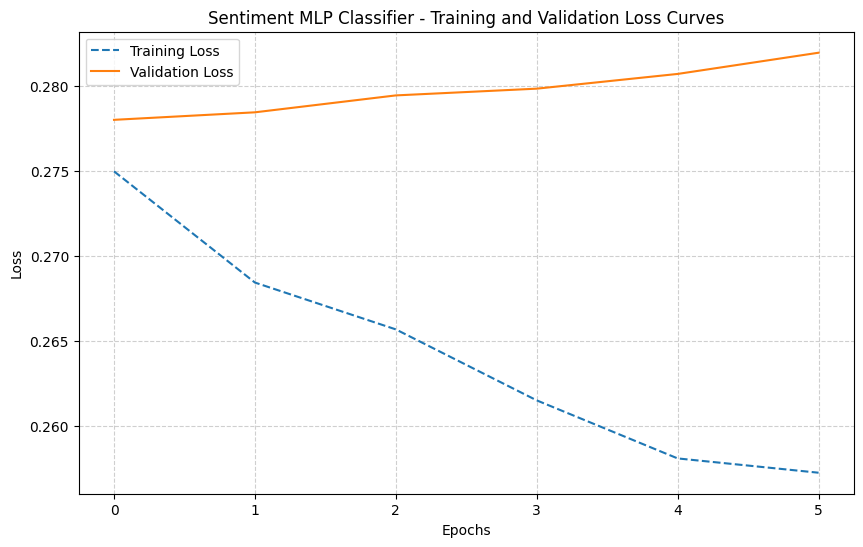


=== PER-CLASS METRICS ===
Class     Split     Precision   Recall      F1          PR-AUC      
-----------------------------------------------------------------
0         Train     0.9091        0.8992        0.9041        0.9663
0         Dev       0.8872        0.8817        0.8844        0.9559
0         Test      0.8783        0.8741        0.8762        0.9498
-----------------------------------------------------------------
1         Train     0.9007        0.9104        0.9055        0.9650
1         Dev       0.8814        0.8869        0.8841        0.9496
1         Test      0.8747        0.8789        0.8768        0.9470
-----------------------------------------------------------------

=== MACRO-AVERAGED METRICS ===
Split     Accuracy    Precision   Recall      F1          PR-AUC      
-----------------------------------------------------------------
Train     0.9048        0.9049        0.9048        0.9048        0.9656
Dev       0.8843        0.8843        0.8843      

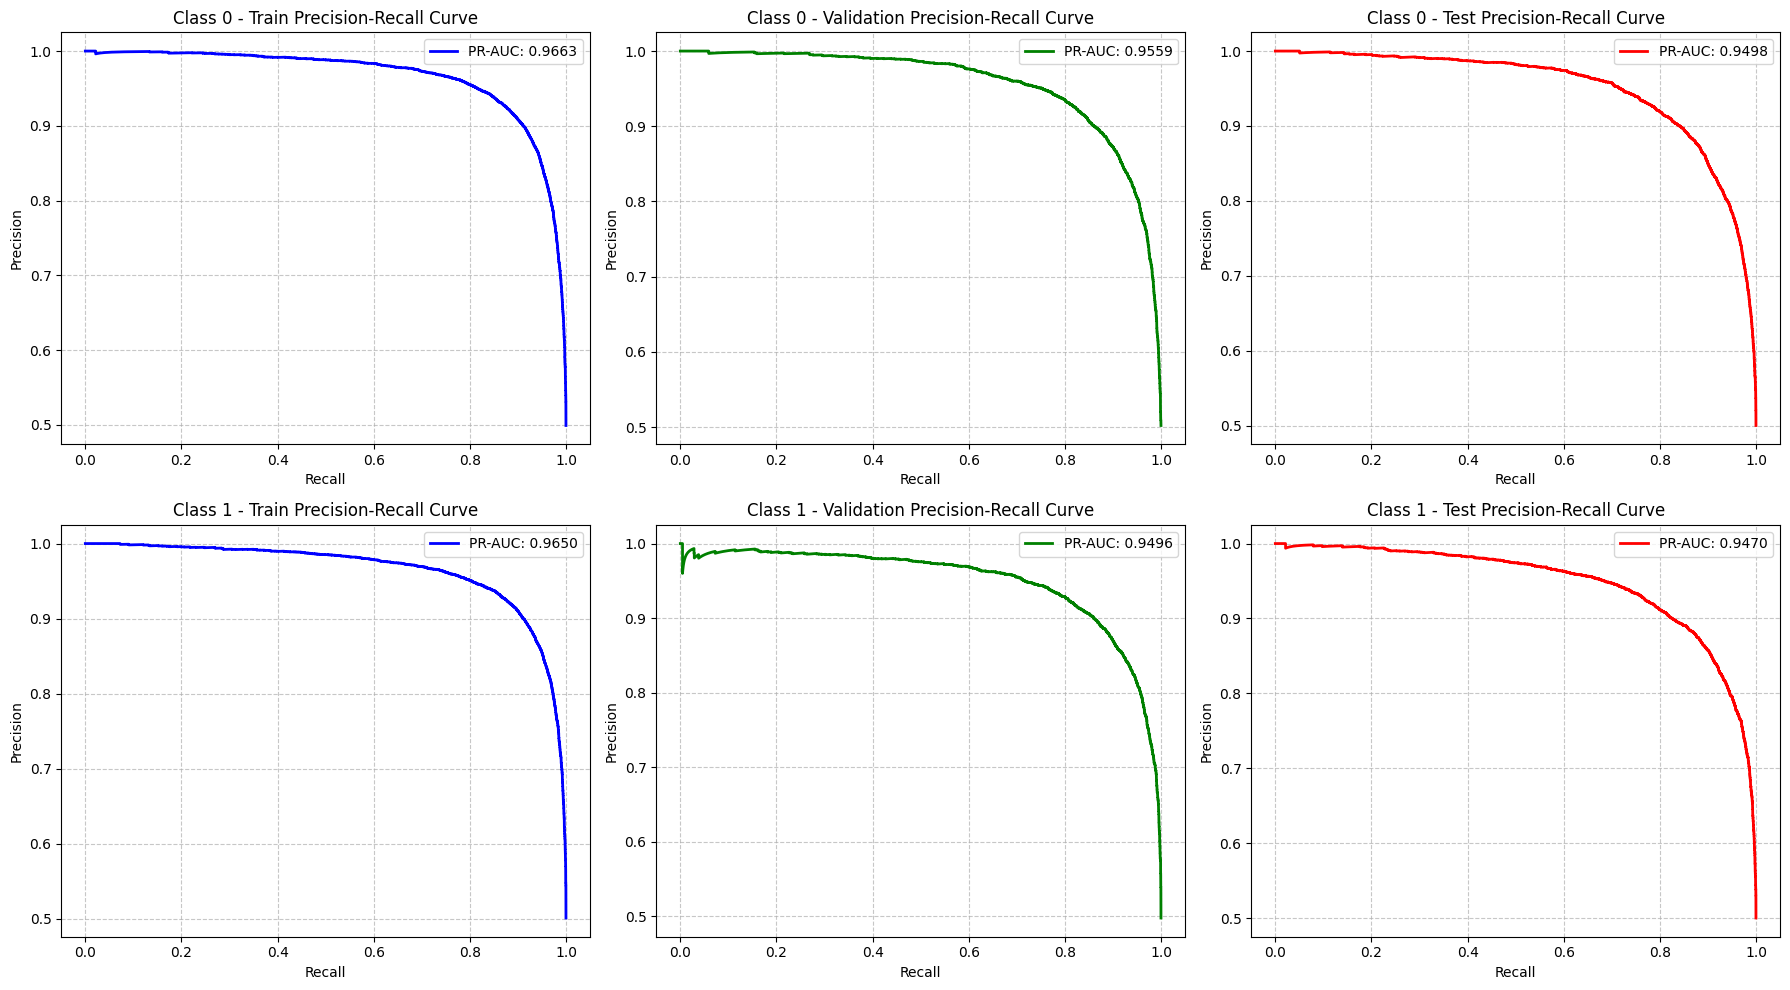

In [59]:
# Plot loss curves
plot_loss_curves(train_losses, val_losses, title="Sentiment MLP Classifier")

# Get detailed evaluation metrics
all_metrics = evaluate_model_detailed(model, train_loader, val_loader, test_loader)

# Store results for potential comparison with other models
results = {
    "model": model,
    "train_losses": train_losses,
    "val_losses": val_losses,
    "all_metrics": all_metrics
}

In [73]:
# Create the comparison with the correct structures
models_comparison = {
    'Baseline': baseline_metrics,
    'MLP Classifier': all_metrics
}

# Print comparison table for test set
print("\n=== MODEL COMPARISON (TEST SET) ===")
print(f"{'Model':<20}{'Accuracy':<12}{'Precision':<12}{'Recall':<12}{'F1':<12}{'PR-AUC':<12}")
print("-" * 75)

for model_name, metrics in models_comparison.items():
    # Access test metrics based on the different structures
    if model_name == 'Baseline':
        test_metrics = metrics['test']
    else:  # MLP Classifier
        test_metrics = metrics['test']['macro']  # The MLP metrics have a nested 'macro' key

    print(f"{model_name:<20}{test_metrics['accuracy']:.4f}{' '*8}{test_metrics['macro_precision']:.4f}{' '*8}{test_metrics['macro_recall']:.4f}{' '*8}{test_metrics['macro_f1']:.4f}{' '*8}{test_metrics['macro_pr_auc']:.4f}")


=== MODEL COMPARISON (TEST SET) ===
Model               Accuracy    Precision   Recall      F1          PR-AUC      
---------------------------------------------------------------------------
Baseline            0.7767        0.7767        0.7767        0.7767        0.8325
MLP Classifier      0.8765        0.8765        0.8765        0.8765        0.9484


In [72]:
# Debug prints
print("Type of baseline_metrics:", type(baseline_metrics))
print("Keys in baseline_metrics:", list(baseline_metrics.keys()) if hasattr(baseline_metrics, 'keys') else "No keys")

print("Type of all_metrics:", type(all_metrics))
print("Structure of all_metrics:", all_metrics)

Type of baseline_metrics: <class 'dict'>
Keys in baseline_metrics: ['train', 'val', 'test']
Type of all_metrics: <class 'dict'>
Structure of all_metrics: {'train': {'class': {0: {'precision': 0.9090533278214138, 'recall': 0.8992393882391428, 'f1': 0.9041197269961352, 'pr_auc': 0.9662703886597409}, 1: {'precision': 0.9006852075775896, 'recall': 0.9103723620956571, 'f1': 0.9055028770564876, 'pr_auc': 0.964990984337193}}, 'macro': {'accuracy': 0.9048163265306123, 'macro_precision': 0.9048692676995017, 'macro_recall': 0.9048058751674, 'macro_f1': 0.9048113020263113, 'macro_pr_auc': 0.965630686498467}}, 'val': {'class': {0: {'precision': 0.8872137404580153, 'recall': 0.8816612933813768, 'f1': 0.8844288024350804, 'pr_auc': 0.9559051867799322}, 1: {'precision': 0.8813688212927757, 'recall': 0.8869332312990243, 'f1': 0.8841422713836178, 'pr_auc': 0.9495853483204073}}, 'macro': {'accuracy': 0.8842857142857142, 'macro_precision': 0.8842912808753955, 'macro_recall': 0.8842972623402006, 'macro_f1'

Label mapping: {'negative': 0, 'positive': 1}
Training Linear (BoW)...
Epoch:    0 / 20 | Training Loss: 0.47555, Validation Loss: 0.39035
Epoch:    5 / 20 | Training Loss: 0.26897, Validation Loss: 0.30944
Epoch:   10 / 20 | Training Loss: 0.24995, Validation Loss: 0.31368
Epoch:   15 / 20 | Training Loss: 0.24281, Validation Loss: 0.32185
Training Plain MLP (BoW)...
Epoch:    0 / 20 | Training Loss: 0.37363, Validation Loss: 0.32509
Epoch:    5 / 20 | Training Loss: 0.02782, Validation Loss: 0.57161
Epoch:   10 / 20 | Training Loss: 0.00031, Validation Loss: 1.03333
Epoch:   15 / 20 | Training Loss: 0.00005, Validation Loss: 1.22600
Training MLP with Dropout (BoW)...
Epoch:    0 / 20 | Training Loss: 0.41019, Validation Loss: 0.30468
Epoch:    5 / 20 | Training Loss: 0.12263, Validation Loss: 0.38545
Epoch:   10 / 20 | Training Loss: 0.05850, Validation Loss: 0.56623
Epoch:   15 / 20 | Training Loss: 0.03792, Validation Loss: 0.60213
Training MLP with BatchNorm (BoW)...
Epoch:    0 /

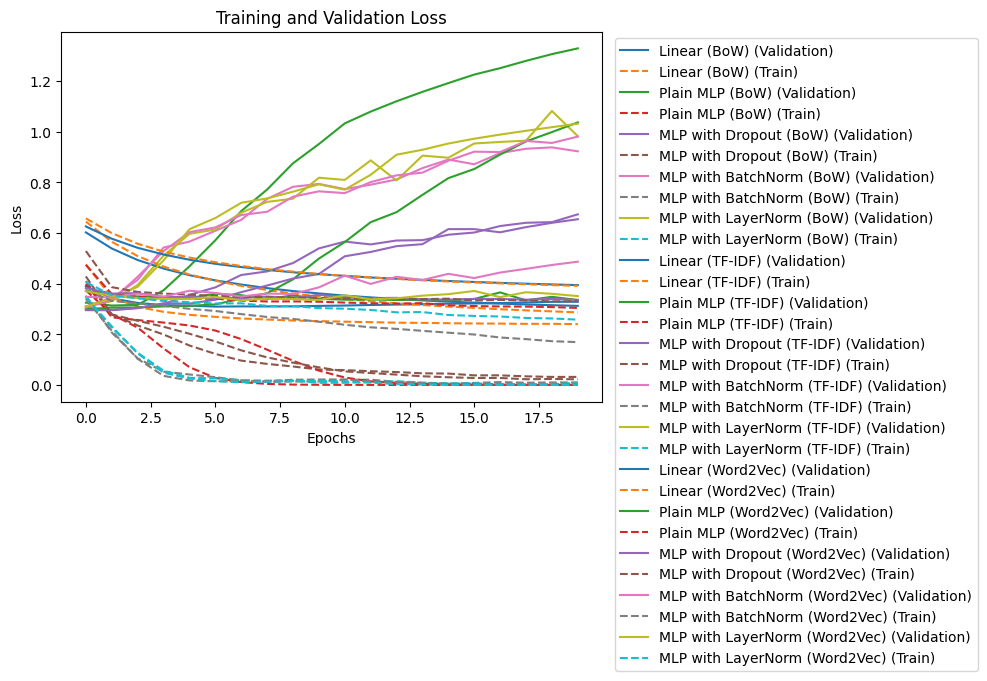


Linear (BoW) Metrics:
Accuracy: 0.8704
Precision: 0.8705
Recall: 0.8704
F1 Score: 0.8704

Plain MLP (BoW) Metrics:
Accuracy: 0.8553
Precision: 0.8554
Recall: 0.8553
F1 Score: 0.8553

MLP with Dropout (BoW) Metrics:
Accuracy: 0.8641
Precision: 0.8642
Recall: 0.8641
F1 Score: 0.8641

MLP with BatchNorm (BoW) Metrics:
Accuracy: 0.8531
Precision: 0.8536
Recall: 0.8531
F1 Score: 0.8531

MLP with LayerNorm (BoW) Metrics:
Accuracy: 0.8545
Precision: 0.8555
Recall: 0.8545
F1 Score: 0.8544

Linear (TF-IDF) Metrics:
Accuracy: 0.8765
Precision: 0.8768
Recall: 0.8765
F1 Score: 0.8764

Plain MLP (TF-IDF) Metrics:
Accuracy: 0.8587
Precision: 0.8590
Recall: 0.8587
F1 Score: 0.8587

MLP with Dropout (TF-IDF) Metrics:
Accuracy: 0.8683
Precision: 0.8683
Recall: 0.8683
F1 Score: 0.8683

MLP with BatchNorm (TF-IDF) Metrics:
Accuracy: 0.8541
Precision: 0.8544
Recall: 0.8541
F1 Score: 0.8541

MLP with LayerNorm (TF-IDF) Metrics:
Accuracy: 0.8562
Precision: 0.8562
Recall: 0.8562
F1 Score: 0.8562

Linear (Wo

In [51]:
# # Main script
# representations = {"BoW": "bow", "TF-IDF": "tfidf", "Word2Vec": "embeddings"}

# results = {}
# epochs = 20  # adjust according to preference...
# batch_size = 128

# for rep_name, rep_type in representations.items():
#     (X_train, y_train), (X_val, y_val), (X_test, y_test) = preprocess_data(train_data, test_data, representation=rep_type)
#     train_dataset = TensorDataset(torch.FloatTensor(X_train).to(device),
#                                   torch.LongTensor(y_train).to(device))
#     val_dataset = TensorDataset(torch.FloatTensor(X_val).to(device),
#                                 torch.LongTensor(y_val).to(device))
#     test_dataset = TensorDataset(torch.FloatTensor(X_test).to(device),
#                                  torch.LongTensor(y_test).to(device))

#     train_loader = DataLoader(train_dataset, batch_size=batch_size,
#                               shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size)
#     test_loader = DataLoader(test_dataset, batch_size=batch_size)

#     input_dim = X_train.shape[1]

#     for model_name, hidden_layers in models_config.items():
#         model_key = f"{model_name} ({rep_name})"
#         model = CustomModel(input_dim, hidden_layers=hidden_layers,
#                             dropout=0.5 if "Dropout" in model_name else 0.0,
#                             batch_norm="BatchNorm" in model_name,
#                             layer_norm="LayerNorm" in model_name,
#                             classes_number=len(np.unique(y_train))
#                             ).float().to(device)
#         criterion = nn.CrossEntropyLoss()
#         optimizer = optim.Adam(model.parameters(), lr=0.001)

#         print(f"Training {model_key}...")
#         train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, epochs)
#         results[model_key] = {
#             "train_losses": train_losses,
#             "val_losses": val_losses,
#             "metrics": evaluate_model(model, test_loader)
#         }


# # Plot losses
# plt.figure(figsize=(10, 6))
# for name, result in results.items():
#     plt.plot(result["val_losses"], label=f"{name} (Validation)")
#     plt.plot(result["train_losses"], linestyle='--', label=f"{name} (Train)")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.title("Training and Validation Loss")
# plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
# plt.tight_layout()
# plt.show()

# # Print metrics
# for name, result in results.items():
#     accuracy, precision, recall, f1 = result["metrics"]
#     print(f"\n{name} Metrics:")
#     print(f"Accuracy: {accuracy:.4f}")
#     print(f"Precision: {precision:.4f}")
#     print(f"Recall: {recall:.4f}")
#     print(f"F1 Score: {f1:.4f}")